# Long Short-Term Memory
### Project 2 - Data Science
- Abner Gardia 21285
- Esteban Donis 21610
- Daniel Gomez 21429
- Allan Paniagua 18084

In [1]:
# Bloque 1: Importar librerías y cargar dataset
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, Bidirectional
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from itertools import cycle

C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Con la data limpia, procedemos a preparar los modelos de LSTM

In [2]:
discourses = pd.read_csv('./result/data_cleaned.csv')
discourses.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,text_length,word_count
0,0013cc385424,007ACE74B050,hi isaac going writing face mars natural landf...,4,0,164,27
1,9704a709b505,007ACE74B050,perspective think face natural landform nott t...,5,0,107,15
2,c22adee811b6,007ACE74B050,think face natural landform life mars descover...,0,0,52,8
3,a10d361e54e4,007ACE74B050,life mars would know reason think natural land...,3,0,199,30
4,db3e453ec4e2,007ACE74B050,people thought face formed alieans thought lif...,2,0,52,8


In [3]:
label_encoder = LabelEncoder()
discourses['discourse_effectiveness'] = label_encoder.fit_transform(discourses['discourse_effectiveness'])

X = discourses['discourse_text'].values
y = discourses['discourse_effectiveness'].values

X = [str(text) if not isinstance(text, str) else text for text in X]

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(sequences, padding='post', maxlen=200)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [4]:
y_test = np.array(y_test)

def get_model_stats(model):
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Get number of classes
    n_classes = len(np.unique(y_test))
    
    # Get class names from label encoder
    class_names = label_encoder.classes_
    
    # Function to plot confusion matrix
    def plot_confusion_matrix():
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
    # Function to plot prediction distribution
    def plot_prediction_distribution():
        plt.figure(figsize=(12, 6))
        for i in range(n_classes):
            sns.kdeplot(y_pred_proba[:, i], label=f'Class {i}')
        plt.title('Prediction Probability Distribution')
        plt.xlabel('Probability')
        plt.ylabel('Density')
        plt.legend()
        plt.show()
    
    # Function to plot ROC curves
    def plot_roc_curves():
        # Convert y_test to one-hot encoding
        y_test_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
        
        # Calculate ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        plt.figure(figsize=(10, 8))
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            plt.plot(fpr[i], tpr[i],
                    label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc="lower right")
        plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))
    
    # Generate all visualizations
    print("\nGenerating Confusion Matrix...")
    plot_confusion_matrix()
    
    print("\nGenerating ROC Curves...")
    plot_roc_curves()
    
    print("\nGenerating Prediction Distribution...")
    plot_prediction_distribution()
    
    # Print model accuracy
    test_loss, test_accuracy = model1.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
import pickle

In [7]:
vocab_size = 10000
input_length = 200

### Model 1
##### Simple LSTM

In [8]:
# Modelo 1: Bidirectional LSTM con Dropout
model1 = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=input_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dense(3, activation='softmax')
])
model1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
# Entrenar y guardar el modelo 1
model1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
model1.evaluate(X_test, y_test)
with open('model1.pkl', 'wb') as file:
    pickle.dump(model1, file)

Epoch 1/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 332s 352ms/step - accuracy: 0.6150 - loss: 0.8765 - val_accuracy: 0.6482 - val_loss: 0.7939
Epoch 2/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 362s 393ms/step - accuracy: 0.6725 - loss: 0.7427 - val_accuracy: 0.6476 - val_loss: 0.7910
Epoch 3/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 369s 401ms/step - accuracy: 0.7217 - loss: 0.6620 - val_accuracy: 0.6455 - val_loss: 0.8196
Epoch 4/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 406s 441ms/step - accuracy: 0.7619 - loss: 0.5793 - val_accuracy: 0.6290 - val_loss: 0.8737
Epoch 5/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 401s 436ms/step - accuracy: 0.8019 - loss: 0.4959 - val_accuracy: 0.6211 - val_loss: 0.9533
230/230 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.6170 - loss: 0.9571


230/230 ━━━━━━━━━━━━━━━━━━━━ 26s 109ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.76      0.71      4246
           1       0.58      0.59      0.58      1825
           2       0.43      0.21      0.29      1282

    accuracy                           0.62      7353
   macro avg       0.56      0.52      0.53      7353
weighted avg       0.60      0.62      0.60      7353


Generating Confusion Matrix...


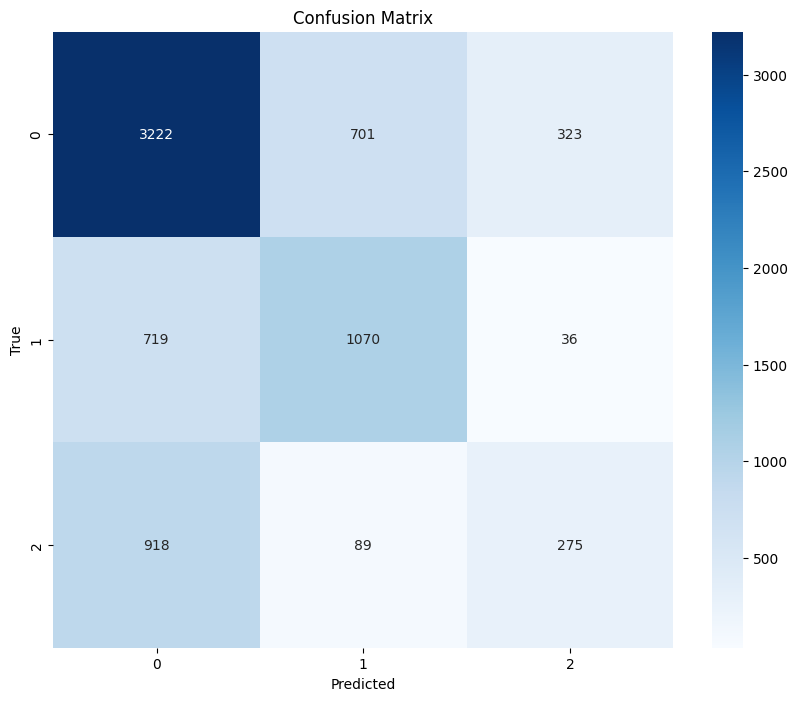


Generating ROC Curves...


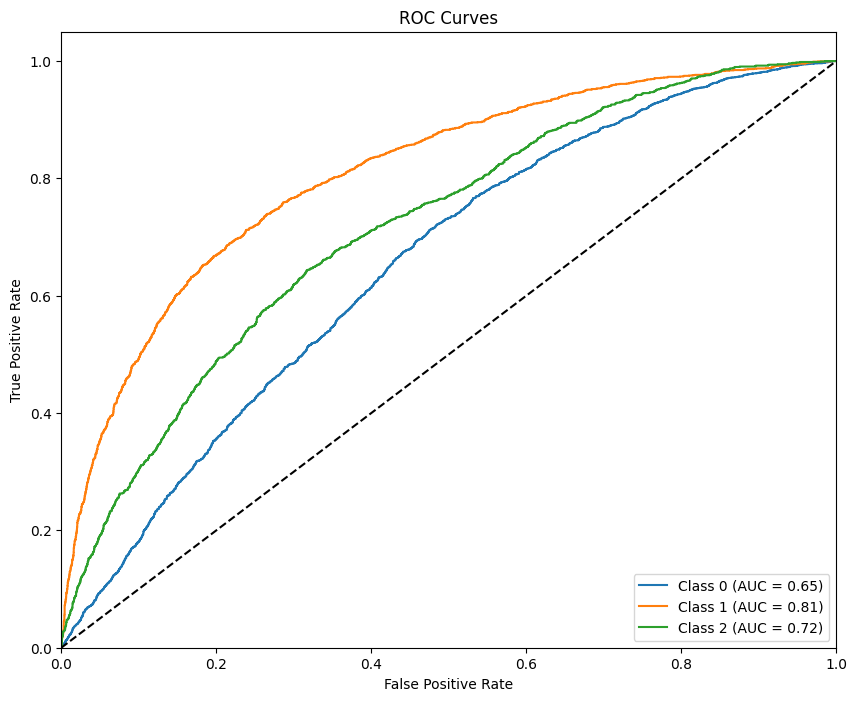


Generating Prediction Distribution...


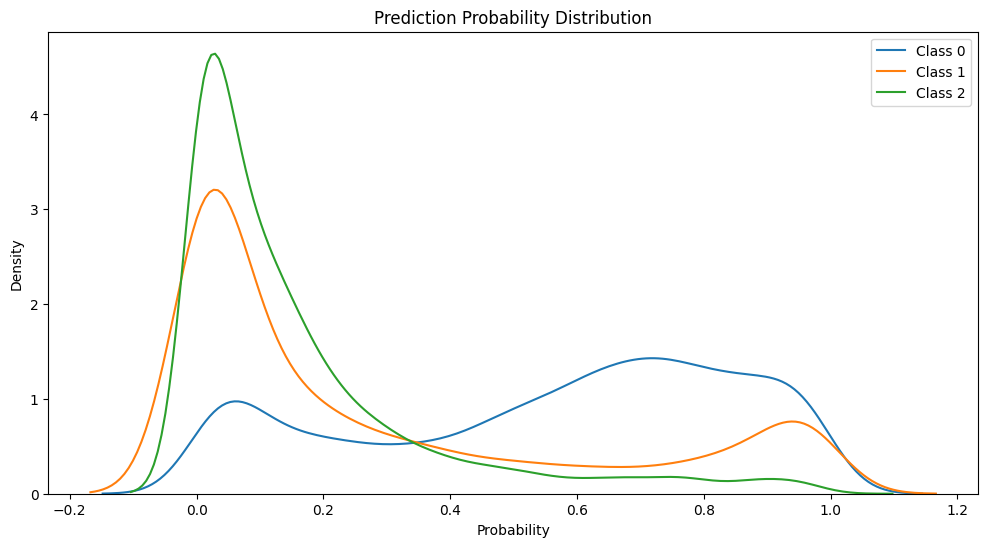


Test Accuracy: 0.6211


In [10]:
get_model_stats(model1)

### Model 2
##### Bidirectional LSTM

In [11]:
# Modelo 2: Bidirectional LSTM con más unidades y diferente optimizador
model2 = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=256, input_length=input_length),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(128)),
    Dense(3, activation='softmax')
])
model2.compile(optimizer=RMSprop(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
# Entrenar y guardar el modelo 2
model2.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
model2.evaluate(X_test, y_test)
with open('model2.pkl', 'wb') as file:
    pickle.dump(model2, file)

Epoch 1/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 1544s 2s/step - accuracy: 0.6085 - loss: 0.9055 - val_accuracy: 0.6403 - val_loss: 0.8258
Epoch 2/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 1631s 2s/step - accuracy: 0.6530 - loss: 0.7915 - val_accuracy: 0.6523 - val_loss: 0.7905
Epoch 3/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 1552s 2s/step - accuracy: 0.6765 - loss: 0.7484 - val_accuracy: 0.6422 - val_loss: 0.8104
Epoch 4/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 1472s 2s/step - accuracy: 0.6883 - loss: 0.7222 - val_accuracy: 0.6320 - val_loss: 0.8227
Epoch 5/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 1431s 2s/step - accuracy: 0.7037 - loss: 0.6966 - val_accuracy: 0.6400 - val_loss: 0.8114
230/230 ━━━━━━━━━━━━━━━━━━━━ 79s 346ms/step - accuracy: 0.6435 - loss: 0.8080


230/230 ━━━━━━━━━━━━━━━━━━━━ 74s 318ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.79      0.72      4246
           1       0.65      0.54      0.59      1825
           2       0.44      0.28      0.34      1282

    accuracy                           0.64      7353
   macro avg       0.59      0.54      0.55      7353
weighted avg       0.62      0.64      0.63      7353


Generating Confusion Matrix...


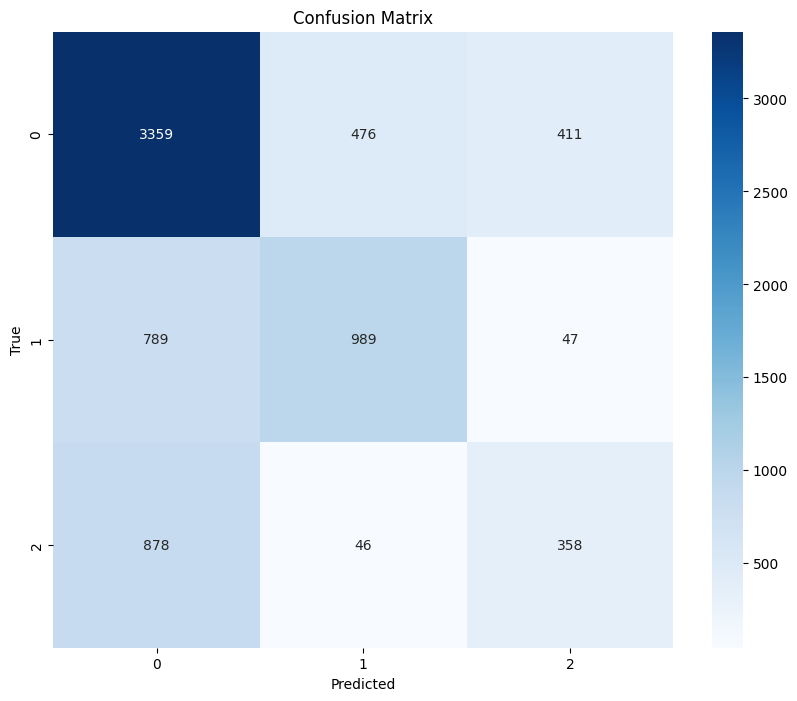


Generating ROC Curves...


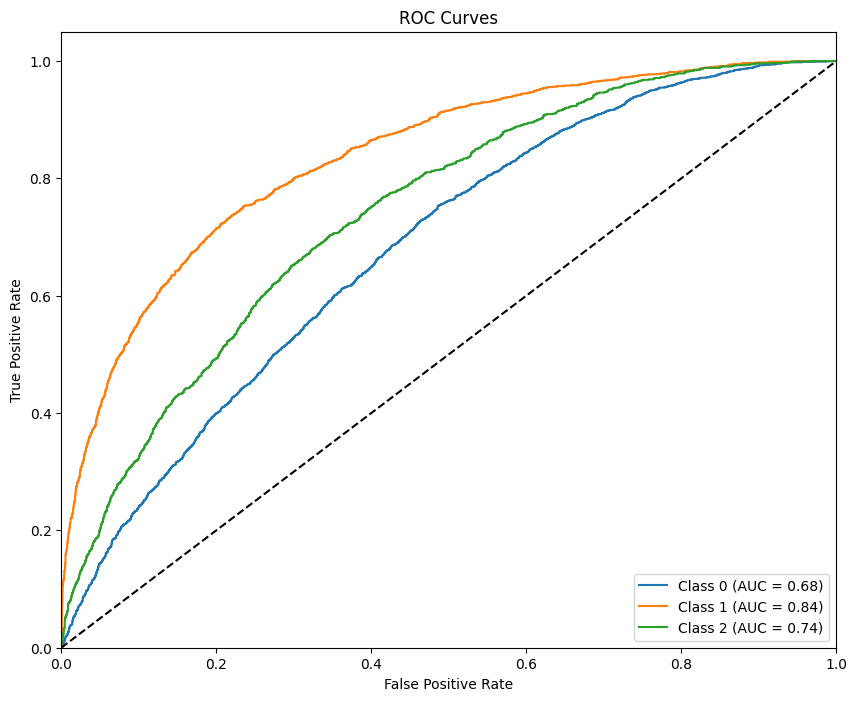


Generating Prediction Distribution...


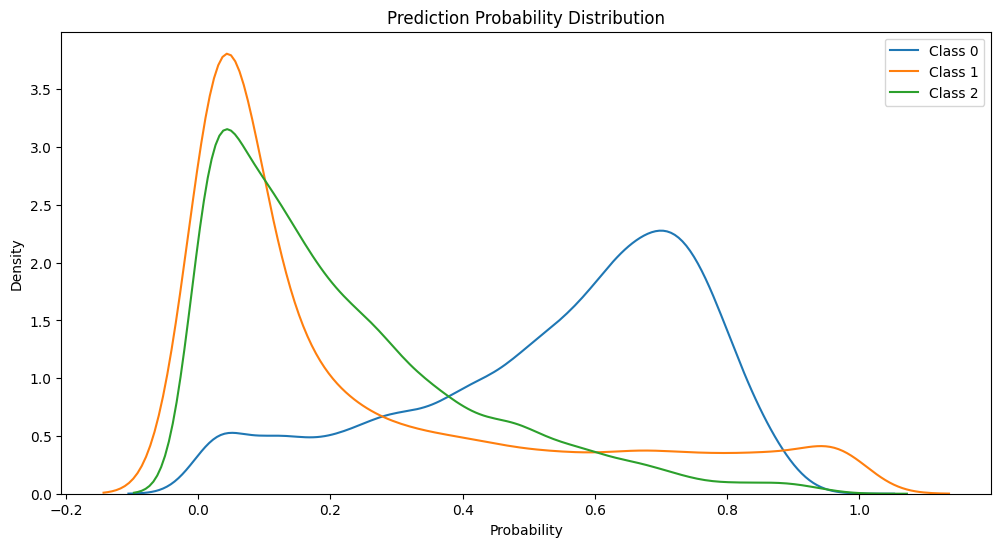


Test Accuracy: 0.6211


In [13]:
get_model_stats(model2)

### Model 3
##### LSTM with Dropout

In [14]:
# Modelo 3: Bidirectional LSTM más profundo con una capa densa adicional
model3 = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=input_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


C:\Users\Personal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
# Entrenar y guardar el modelo 3
model3.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
model3.evaluate(X_test, y_test)
with open('model3.pkl', 'wb') as file:
    pickle.dump(model3, file)

Epoch 1/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 457s 481ms/step - accuracy: 0.5850 - loss: 0.9599 - val_accuracy: 0.6335 - val_loss: 0.8274
Epoch 2/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 447s 486ms/step - accuracy: 0.6435 - loss: 0.8111 - val_accuracy: 0.6512 - val_loss: 0.7903
Epoch 3/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 473s 515ms/step - accuracy: 0.6740 - loss: 0.7499 - val_accuracy: 0.6552 - val_loss: 0.7820
Epoch 4/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 468s 509ms/step - accuracy: 0.6963 - loss: 0.7029 - val_accuracy: 0.6551 - val_loss: 0.7914
Epoch 5/5
920/920 ━━━━━━━━━━━━━━━━━━━━ 490s 533ms/step - accuracy: 0.7195 - loss: 0.6595 - val_accuracy: 0.6437 - val_loss: 0.8198
230/230 ━━━━━━━━━━━━━━━━━━━━ 33s 142ms/step - accuracy: 0.6418 - loss: 0.8234


230/230 ━━━━━━━━━━━━━━━━━━━━ 31s 130ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73      4246
           1       0.60      0.62      0.61      1825
           2       0.54      0.17      0.25      1282

    accuracy                           0.64      7353
   macro avg       0.60      0.53      0.53      7353
weighted avg       0.63      0.64      0.62      7353


Generating Confusion Matrix...


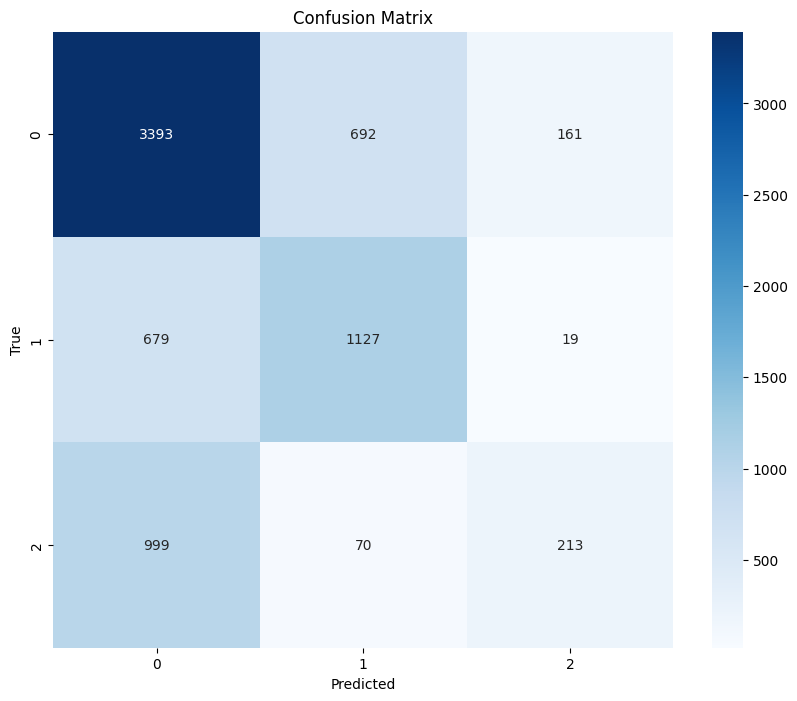


Generating ROC Curves...


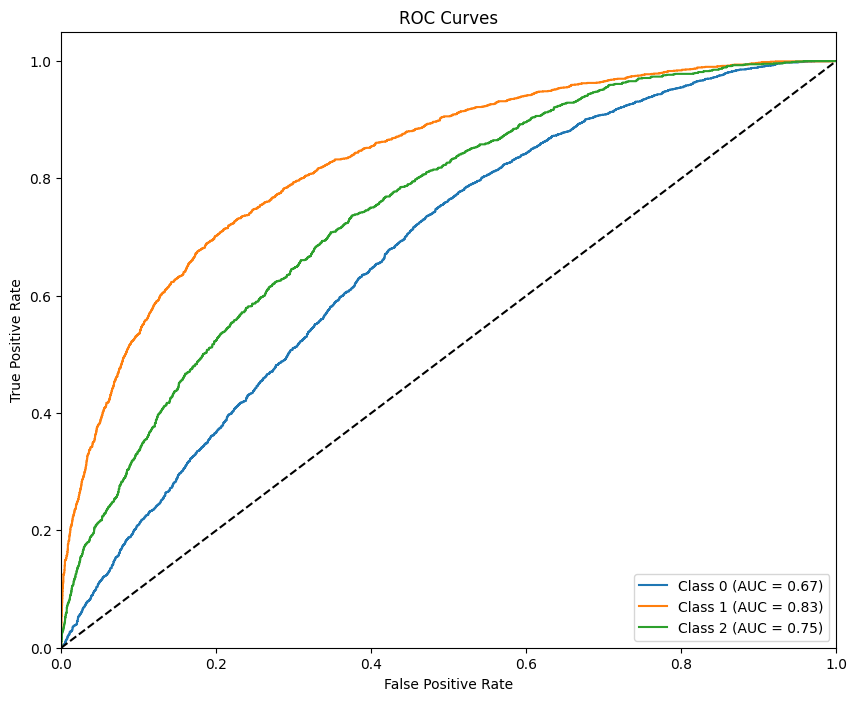


Generating Prediction Distribution...


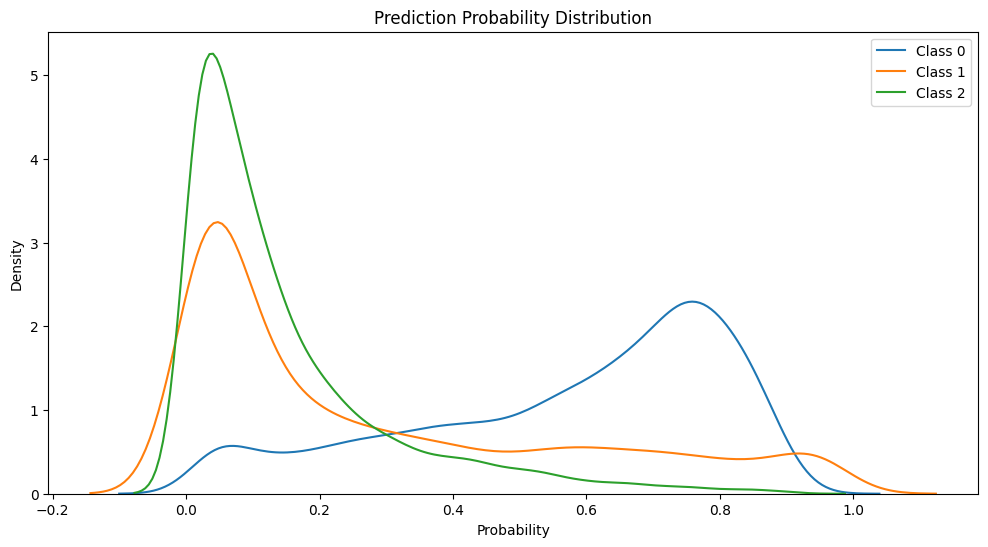


Test Accuracy: 0.6211


In [16]:
get_model_stats(model3)